<a href="https://colab.research.google.com/github/willismax/ML-in-Production-30-days-sharing/blob/main/notebook/27.TensorFlow_Serving_REST_API_%E9%90%B5%E4%BA%BA%E8%B3%BD%E7%A4%BA%E7%AF%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  TensorFlow Serving REST API - 鐵人賽示範

- 本篇為[鐵人賽](https://ithelp.ithome.com.tw/articles/10272257)示範，參考[官方範例](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)修改而成。
- 本篇適用在 Colab 環境。

## 下載資料及訓練模型

- 由於重點在如何起一個TF Severing 服務，資料採用`keras.datasets.cifar10`進行示範，[CIFAR10](https://keras.io/api/datasets/cifar10/)為小型的影像分類資料集，具有50,000筆訓練資料集與10,000筆測試資料集，皆為32X32像素圖片。更多資訊參閱[官方介紹](https://www.cs.toronto.edu/~kriz/cifar.html)。


|Label| Description|
|-|-|
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [1]:
# TensorFlow and tf.keras
# !pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

- 建立模型

In [2]:
fashion_mnist = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)
test_images = test_images.reshape(test_images.shape[0], 32, 32, 3)

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


print(f'train_images.shape: {train_images.shape}, of {train_images.dtype}')
print(f'test_images.shape: {test_images.shape}, of {test_images.dtype}')

170508288/170498071 [==============================] - 3s 0us/step
train_images.shape: (50000, 32, 32, 3), of float64
test_images.shape: (10000, 32, 32, 3), of float64


- 訓練與評估模型

In [3]:
model = keras.Sequential([
  keras.layers.Conv2D(
      input_shape=(32,32,3), 
      filters=8, 
      kernel_size=3, 
      strides=2, 
      activation='relu', 
      name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 5

model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 15, 15, 8)         224       
                                                                 
 flatten (Flatten)           (None, 1800)              0         
                                                                 
 Dense (Dense)               (None, 10)                18010     
                                                                 
Total params: 18,234
Trainable params: 18,234
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1563/1563 [==============================] - 15s 3ms/step - loss: 1.7449 - sparse_categorical_accuracy: 0.3896
Epoch 2/5
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5220 - sparse_categorical_accuracy: 0.4709
Epoch 3/5
1563/1563 [==============================] - 4s 3ms/step - loss: 

### 儲存模型

- 將模型保存為[SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model)格式，以便將模型加載到 TensorFlow Serving 中。
- [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving)允許我們在發出推理請求時選擇要使用的模型版本或“可服務”版本。每個版本將導出到給定路徑下的不同子目錄。為此，需在目錄創建 protobuf 文件，並將包含一個版本號。 
- 以下會在`/tmp/`建立版次版次`version = 1`之相關檔案。

In [4]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print(f'export_path = {export_path}')

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 92
drwxr-xr-x 2 root root  4096 May 19 05:07 assets
-rw-r--r-- 1 root root  8228 May 19 05:07 keras_metadata.pb
-rw-r--r-- 1 root root 72310 May 19 05:07 saved_model.pb
drwxr-xr-x 2 root root  4096 May 19 05:07 variables


### 檢查我們的Saved model

- `saved_model_cli` 可以檢查前述[SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef)中相關資訊，這對理解模型相當有用，包含:
  - [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef)（模型）
  - [SignatureDefs](https://www.tensorflow.org/tfx/tutorials/signature_defs)（您可以調用的方法）
- SavedModel CLI的詳細說明可參閱[TensorFlow 指南](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel)。

In [5]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 3)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          Conv1_input

### 建立 TensorFlow Serving 服務 


- 依官方範例此為Colab環境所需設定內容，如使用本機端的 Notebook ，請注意相關提醒。

#### Add TensorFlow Serving distribution URI as a package source

- 我們準備使用[Aptitude](https://wiki.debian.org/Aptitude)安裝 TensorFlow Serving，因為此 Colab 在 Debian 環境中運行。我們將把這個`tensorflow-model-server`包添加到 Aptitude 知道的包列表中。請注意，我們以 root 身份運行。
- 最簡單的方式是以 Docker 佈署，您可以參考此[範例](https://www.tensorflow.org/tfx/serving/docker)。

In [6]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [7]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  18055      0 --:--:-- --:--:-- --:--:-- 18055
OK
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://arc

### 安裝 TensorFlow Serving


In [8]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 47 not upgraded.
Need to get 340 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.8.0 [340 MB]
Fetched 340 MB in 4s (82.8 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model-server (2.8.0) ...


### 啟動 TensorFlow Serving

加載後，我們可以開始使用 REST 發出推理請求，相關參數:

-   `rest_api_port`： REST 請求的 Port。
-   `model_name`：您將在 REST 請求的 URL 中使用它。
-   `model_base_path`：保存模型的目錄的路徑。

In [9]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [10]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 0 in a separate thread.


In [11]:
!tail server.log

## 以 Request 向 TensorFlow Serving 提出請求提出請求

- 先以亂數查看 test data。

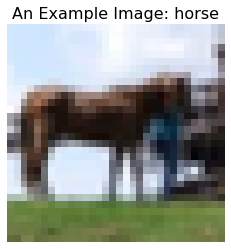

In [12]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(32,32,3))
  plt.axis('off')
  plt.title(f'{title}', fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
test_label_name = class_names[int(test_labels[rando])]
show(rando, f'An Example Image: {test_label_name}')

- 測試請求一批JSON。

In [13]:
import json
from pprint import pprint

data = json.dumps(
    {"signature_name": "serving_default", 
     "instances": test_images[0:3].tolist()}
     )
pprint(f'Data: {data[:50]} ... {data[len(data)-52:]}')

('Data: {"signature_name": "serving_default", "instances": ... 6862, '
 '0.03137254901960784, 0.027450980392156862]]]]}')


### 發出 REST 請求

### 最新版本的 servable

- 以 POST 至 server，預設請求伺服器提供最新版次的內容。

In [14]:
# docs_infra: no_execute
!pip install -q requests

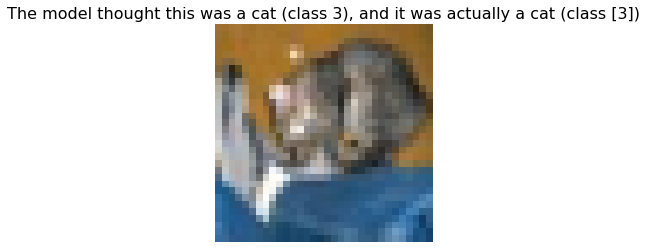

In [15]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post(
    'http://localhost:8501/v1/models/fashion_model:predict', 
    data=data, 
    headers=headers
    )

predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[int(test_labels[0])], test_labels[0]))

### 指定特定版本服務

- 以REST API 向伺服器請求指定版本`version = 1`。

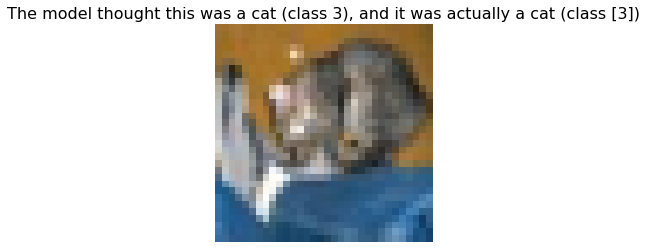

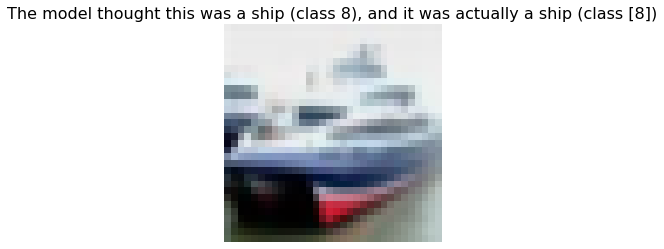

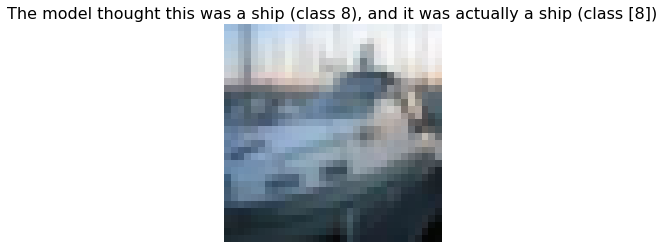

In [16]:
# docs_infra: no_execute
version = 1

headers = {"content-type": "application/json"}
json_response = requests.post(
    f'http://localhost:8501/v1/models/fashion_model/versions/{version}:predict', 
    data=data, 
    headers=headers
    )

predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[int(test_labels[i])], test_labels[i]))